[View in Colaboratory](https://colab.research.google.com/github/hasbrain/deeplearning-path/blob/master/ImprovingDNN/%Assignment%5DBasicDNNDecipherSignLanguageClassification.ipynb)

# Build Basic DNN with Tensorflow to classify Decipher Sign Language

This notebook is written by [hasBrain](https://github.com/hasbrain), following the tutorial of [Gurupradeep](https://github.com/Gurupradeep)

## 1 - Exploring the Tensorflow Library

To start, you will download dataset and import the library:


In [1]:
!curl https://raw.githubusercontent.com/hasbrain/deeplearning-path/master/datasets/train_signs.h5 -o train_signs.h5
!curl https://raw.githubusercontent.com/hasbrain/deeplearning-path/master/datasets/test_signs.h5 -o test_signs.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.6M  100 12.6M    0     0  2090k      0  0:00:06  0:00:06 --:--:-- 2615k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1443k  100 1443k    0     0   588k      0  0:00:02  0:00:02 --:--:--  588k


In [32]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [5]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

Now that you have imported the library, we will walk you through its different applications. You will start with an example, where we compute for you the loss of one training example. 
$$loss = \mathcal{L}(\hat{y}, y) = (\hat y^{(i)} - y^{(i)})^2 \tag{1}$$

In [6]:
y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss

init = tf.global_variables_initializer()         # When init is run later (session.run(init)),
                                                 # the loss variable will be initialized and ready to be computed
with tf.Session() as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))                     # Prints the loss

9


Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated. 
2. Write operations between those Tensors.
3. Initialize your Tensors. 
4. Create a Session. 
5. Run the Session. This will run the operations you'd written above. 

Therefore, when we created a variable for the loss, we simply defined the loss as a function of other quantities, but did not evaluate its value. To evaluate it, we had to run `init=tf.global_variables_initializer()`. That initialized the loss variable, and in the last line we were finally able to evaluate the value of `loss` and print its value.

Now let us look at an easy example. Run the cell below:

In [7]:
a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
print(c)

Tensor("Mul:0", shape=(), dtype=int32)


As expected, you will not see 20! You got a tensor saying that the result is a tensor that does not have the shape attribute, and is of type "int32". All you did was put in the 'computation graph', but you have not run this computation yet. In order to actually multiply the two numbers, you will have to create a session and run it.

In [8]:
sess = tf.Session()
print(sess.run(c))

20


Great! To summarize, **remember to initialize your variables, create a session and run the operations inside the session**. 

Next, you'll also have to know about placeholders. A placeholder is an object whose value you can specify only later. 
To specify values for a placeholder, you can pass in values by using a "feed dictionary" (`feed_dict` variable). Below, we created a placeholder for x. This allows us to pass in a number later when we run the session. 

In [9]:
# Change the value of x in the feed_dict

x = tf.placeholder(tf.int64, name = 'x')
print(sess.run(2 * x, feed_dict = {x: 3}))
sess.close()

6


When you first defined `x` you did not have to specify a value for it. A placeholder is simply a variable that you will assign data to only later, when running the session. We say that you **feed data** to these placeholders when running the session. 

Here's what's happening: When you specify the operations needed for a computation, you are telling TensorFlow how to construct a computation graph. The computation graph can have some placeholders whose values you will specify only later. Finally, when you run the session, you are telling TensorFlow to execute the computation graph.

### 1.1 - Linear function

Lets start this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

#### TODO 1: linear_function
**Exercise**: Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, here is how you would define a constant X that has shape (3,1):
```python
X = tf.constant(np.random.randn(3,1), name = "X")

```
You might find the following functions helpful: 
- tf.matmul(..., ...) to do a matrix multiplication
- tf.add(..., ...) to do an addition
- np.random.randn(...) to initialize randomly


In [10]:
def linear_function():
    """
    Implements a linear function: 
            Initializes W to be a random tensor of shape (4,3)
            Initializes X to be a random tensor of shape (3,1)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- runs the session for Y = WX + b 
    """
    
    np.random.seed(1)
    
    ### START CODE HERE ### (4 lines of code)
    X = tf.constant(np.random.randn(3,1),name = "X")
    W = tf.constant(np.random.randn(4,3),name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X),b)
    ### END CODE HERE ### 
    
    # Create the session using tf.Session() and run it with sess.run(...) on the variable you want to calculate
    
    ### START CODE HERE ###
    sess = tf.Session()
    result = sess.run(Y)
    ### END CODE HERE ### 
    
    # close the session 
    sess.close()

    return result

In [11]:
print( "result = " + str(linear_function()))

result = [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


***Expected Output*** : 

<table> 
<tr> 
<td>
    <b>result</b>
</td>
<td>
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]
</td>
</tr> 
</table> 

### 1.2 - Computing the sigmoid 
Great! You just implemented a linear function. Tensorflow offers a variety of commonly used neural network functions like `tf.sigmoid` and `tf.softmax`. For this exercise lets compute the sigmoid function of an input. 

You will do this exercise using a placeholder variable `x`. When running the session, you should use the feed dictionary to pass in the input `z`. In this exercise, you will have to (i) create a placeholder `x`, (ii) define the operations needed to compute the sigmoid using `tf.sigmoid`, and then (iii) run the session. 

#### TODO 2: sigmoid
** Exercise ** : Implement the sigmoid function below. You should use the following: 

- `tf.placeholder(tf.float32, name = "...")`
- `tf.sigmoid(...)`
- `sess.run(..., feed_dict = {x: z})`


Note that there are two typical ways to create and use sessions in tensorflow: 

**Method 1:**
```python
sess = tf.Session()
# Run the variables initialization (if needed), run the operations
result = sess.run(..., feed_dict = {...})
sess.close() # Close the session
```
**Method 2:**
```python
with tf.Session() as sess: 
    # run the variables initialization (if needed), run the operations
    result = sess.run(..., feed_dict = {...})
    # This takes care of closing the session for you :)
```


In [12]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    
    ### START CODE HERE ### ( approx. 4 lines of code)
    # Create a placeholder for x. Name it 'x'.
    x = tf.placeholder(tf.float32)

    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)

    # Create a session, and run it. Please use the method 2 explained above. 
    # You should use a feed_dict to pass z's value to x. 
    with tf.Session() as sess:
        # Run session and call the output "result"
        result = sess.run(sigmoid,feed_dict={x:z})
    
    ### END CODE HERE ###
    
    return result

In [13]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999938


***Expected Output*** : 

<table> 
<tr> 
<td>
    <b>sigmoid(0)</b>
</td>
<td>
0.5
</td>
</tr>
<tr> 
<td>
    <b>sigmoid(12)</b>
</td>
<td>
0.999994
</td>
</tr> 
</table> 

**To summarize, you how know how to**:
1. Create placeholders
2. Specify the computation graph corresponding to operations you want to compute
3. Create the session
4. Run the session, using a feed dictionary if necessary to specify placeholder variables' values. 

### 1.3 -  Computing the Cost

You can also use a built-in function to compute the cost of your neural network. So instead of needing to write code to compute this as a function of $a^{[2](i)}$ and $y^{(i)}$ for i=1...m: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

you can do it in one line of code in tensorflow!

#### TODO 3: cost
**Exercise**: Implement the cross entropy loss. The function you will use is: 


- `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)`

Your code should input `z`, compute the sigmoid (to get `a`) and then compute the cross entropy cost $J$. All this can be done using one call to `tf.nn.sigmoid_cross_entropy_with_logits`, which computes

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$



In [14]:
def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    ### START CODE HERE ### 
    
    # Create the placeholders for "logits" (z) and "labels" (y) (approx. 2 lines)
    z = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z, labels = y)
    
    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.Session()
    
    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict = {z : logits, y:labels})
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return cost

In [63]:
logits = sigmoid(np.array([0.2,0.4,0.7,0.9]))
cost = cost(logits, np.array([0,0,1,1]))
print ("cost = " + str(cost))

cost = [ 1.00538719  1.03664088  0.41385433  0.39956614]


**Expected Output** : 

<table> 
    <tr> 
        <td>
            <b>cost</b>
        </td>
        <td>
        [ 1.00538719  1.03664088  0.41385433  0.39956614]
        </td>
    </tr>
</table>

### 1.4 - Using One Hot encodings

Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:


<img src="https://raw.githubusercontent.com/hasbrain/deeplearning-path/master/images/onehot.png" style="width:600px;height:150px;">

This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In tensorflow, you can use one line of code: 

- tf.one_hot(labels, depth, axis) 

#### TODO 4: one_hot_matrix
**Exercise:** Implement the function below to take one vector of labels and the total number of classes $C$, and return the one hot encoding. Use `tf.one_hot()` to do this. 

In [15]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name = "C")
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels,C)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [16]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C = 4)
print ("one_hot = " + str(one_hot))

one_hot = [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


**Expected Output**: 

<table> 
    <tr> 
        <td>
            <b>one_hot</b>
        </td>
        <td>
        [[ 0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.]]
        </td>
    </tr>

</table>


### 1.5 - Initialize with zeros and ones

Now you will learn how to initialize a vector of zeros and ones. The function you will be calling is `tf.ones()`. To initialize with zeros you could use tf.zeros() instead. These functions take in a shape and return an array of dimension shape full of zeros and ones respectively. 

#### TODO 5: ones
**Exercise:** Implement the function below to take in a shape and to return an array (of the shape's dimension of ones). 

 - tf.ones(shape)


In [17]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    
    ### START CODE HERE ###
    
    # Create "ones" tensor using tf.ones(...). (approx. 1 line)
    ones = tf.ones(shape)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session to compute 'ones' (approx. 1 line)
    ones = sess.run(ones)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    return ones

In [18]:
print ("ones = " + str(ones([3])))

ones = [1. 1. 1.]


**Expected Output:**

<table> 
    <tr> 
        <td>
            <b>ones</b>
        </td>
        <td>
        [ 1.  1.  1.]
        </td>
    </tr>
</table>

# 2 - Building your first neural network in tensorflow

In this part of the assignment you will build a neural network using tensorflow. Remember that there are two parts to implement a tensorflow model:

- Create the computation graph
- Run the graph

Let's delve into the problem you'd like to solve!

### 2.0 - Problem statement: SIGNS Dataset

One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="https://raw.githubusercontent.com/hasbrain/deeplearning-path/master/images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [19]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


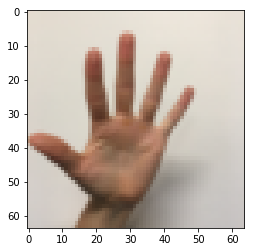

In [20]:
# Example of a picture
index = 3
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [21]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**Your goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, you are going to build a tensorflow model that is almost the same as one you have previously built in numpy for cat recognition (but now using a softmax output). It is a great occasion to compare your numpy implementation to the tensorflow one. 

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 2.1 - Create placeholders

Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 

#### TODO 6: create_placeholders
**Exercise:** Implement the function below to create the placeholders in tensorflow.

In [22]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32,[n_x,None],name = "X")
    Y = tf.placeholder(tf.float32,[n_y,None],name = "Y")
    ### END CODE HERE ###
    
    return X, Y

In [23]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y:0", shape=(6, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            <b>X</b>
        </td>
        <td>
        Tensor("Placeholder_1:0", shape=(12288, ?), dtype=float32) (not necessarily Placeholder_1)
        </td>
    </tr>
    <tr> 
        <td>
            <b>Y</b>
        </td>
        <td>
        Tensor("Placeholder_2:0", shape=(10, ?), dtype=float32) (not necessarily Placeholder_2)
        </td>
    </tr>

</table>

### 2.2 - Initializing the parameters

Your second task is to initialize the parameters in tensorflow.

#### TODO 7: initialize_parameters
**Exercise:** Implement the function below to initialize the parameters in tensorflow. You are going use Xavier Initialization for weights and Zero Initialization for biases. The shapes are given below. As an example, to help you, for W1 and b1 you could use: 

```python
W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
```
Please use `seed = 1` to make sure your results match ours.

In [24]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1",[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1",[25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2",[12,25],initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2",[12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3",[6,12],initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3",[6,1], initializer = tf.zeros_initializer())
   
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [25]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

Instructions for updating:
Use the retry module or similar alternatives.
W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


**Expected Output**: 

<table> 
    <tr> 
        <td>
            <b>W1</b>
        </td>
        <td>
         < tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            <b>b1</b>
        </td>
        <td>
        < tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            <b>W2</b>
        </td>
        <td>
        < tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref >
        </td>
    </tr>
    <tr> 
        <td>
            <b>b2</b>
        </td>
        <td>
        < tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref >
        </td>
    </tr>
</table>

As expected, the parameters haven't been evaluated yet.

### 2.3 - Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

#### TODO 8: forward_propagation
**Question:** Implement the forward pass of the neural network. We commented for you the numpy equivalents so that you can compare the tensorflow implementation to numpy. It is important to note that the forward propagation stops at `z3`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `a3`!



In [26]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                                # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                                # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [27]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            <b>Z3</b>
        </td>
        <td>
        Tensor("Add_2:0", shape=(6, ?), dtype=float32)
        </td>
    </tr>

</table>

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

### 2.4 Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
#### TODO 9: compute_cost
**Question**: Implement the cost function below. 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [28]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [29]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = Tensor("Mean:0", shape=(), dtype=float32)


**Expected Output**: 

<table> 
    <tr> 
        <td>
            <b>cost</b>
        </td>
        <td>
        Tensor("Mean:0", shape=(), dtype=float32)
        </td>
    </tr>

</table>

### 2.5 - Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

### 2.6 - Building the model

Now, you will bring it all together! 

#### TODO 9: model
**Exercise:** Implement the model. You will be calling the functions you had previously implemented.

In [30]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Run the following cell to train your model! On our machine it takes about 5 minutes. Your "Cost after epoch 100" should be 1.016458. If it's not, don't waste time; interrupt the training by clicking on the square (⬛) in the upper bar of the notebook, and try to correct your code. If it is the correct cost, take a break and come back in 5 minutes!

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572940
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381021
Cost after epoch 600: 0.313821
Cost after epoch 700: 0.254158
Cost after epoch 800: 0.203829
Cost after epoch 900: 0.166421
Cost after epoch 1000: 0.141486
Cost after epoch 1100: 0.107577
Cost after epoch 1200: 0.086444
Cost after epoch 1300: 0.059378
Cost after epoch 1400: 0.052267


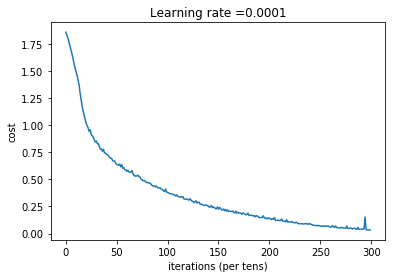

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.71666664


In [33]:
parameters = model(X_train, Y_train, X_test, Y_test)

**Expected Output**:

<table> 
    <tr> 
        <td>
            <b>Train Accuracy</b>
        </td>
        <td>
        0.999074
        </td>
    </tr>
    <tr> 
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
        0.716667
        </td>
    </tr>

</table>

Amazing, your algorithm can recognize a sign representing a figure between 0 and 5 with 71.7% accuracy.

**Insights**:
- Your model seems big enough to fit the training set well. However, given the difference between train and test accuracy, you could try to add L2 or dropout regularization to reduce overfitting. 
- Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

### 2.7 - Test with your own image (optional / ungraded exercise)

Congratulations on finishing this assignment. You can now take a picture of your hand and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right!

Your algorithm predicts: y = 3


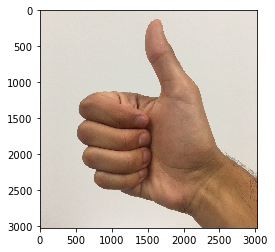

In [91]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

You indeed deserved a "thumbs-up" although as you can see the algorithm seems to classify it incorrectly. The reason is that the training set doesn't contain any "thumbs-up", so the model doesn't know how to deal with it! We call that a "mismatched data distribution" and it is one of the various of the next course on "Structuring Machine Learning Projects".

<font color='blue'>
**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.